In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
# produce V1_allpos, V1_feature, V1_RF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import integrate
from patch_square import *
fdr = 'D:/scratch/patchV1/resource/'

In [3]:
ecc0 = 2
deg2_per_mm2 = ecc0*ecc0*np.pi/2/(217.364/2) # halved for single eye condition (ocular dominance columns for ipsi and contra are mostly balanced)
print(deg2_per_mm2)
# 2.0 ecc yields 217.364 𝑚𝑚2 ~ 0.0289 deg2 per mm2(O'Kusky & Colonnier 1982)
# L2/3 model density ~ 14766.156 per 𝑚𝑚2 (18)
# L4Cbeta model density ~ 24613.409 per 𝑚𝑚2 (30)
# L4Calpha model density ~ 14193.732 per mm2 (17.3)

#    4Cbeta  4Calpha L2/3
# #   480      272    272 = 1024
# E/I 4:1      3:1    3:1  
#              E              I
# block: 384, 204, 204 | 96, 68, 68

# using uniform density
theme = 'square-multi_layer'
den_L2_3 = 46020.984
den_L4beta = 24613.409
den_L4alpha = 14193.732
den = np.array([den_L2_3, den_L4beta, den_L4alpha])
nLayer = 3
nV1 = np.zeros(nLayer, dtype = 'u4')
nblock = np.zeros(nLayer, dtype = 'u4')
blockSize = np.zeros(nLayer, dtype = 'u4')
grid_1D = np.zeros(nLayer, dtype = 'u4')
theme = '_'+theme

deg = 1
ecc = deg/2
warpSize = 32
d0 = 0.5
area = deg*deg/deg2_per_mm2
print(area)
nOP_x = int(np.sqrt(area)/d0)
nOP_y = nOP_x
nOP = nOP_x * nOP_y
d = np.sqrt(area)/nOP_x
r = d/2
w = d*nOP_x
h = d*nOP_y
print(f'diameter of nOP = {d:.4}mm')

0.05781256608435239
17.29727752511337
diameter of nOP = 0.5199mm


In [4]:
for i in range(nLayer):
    nV1[i] = int(round(den[i]*area/warpSize))*warpSize
    nV1_32 = nV1[i]//warpSize
    min_residual = np.inf
    for j in range(2,int(np.sqrt(nV1_32))):
        nWarpPerBlock = round(nV1_32/(j*j))
        residual = abs(nV1_32/(j*j) - nWarpPerBlock)*j*j
        if nWarpPerBlock <= 32 and residual < min_residual:
            min_residual = residual
            nblock[i] = j*j
            grid_1D[i] = j
            blockSize[i] = nWarpPerBlock*warpSize
print(f'putative nV1 = {nV1}')
nV1 = nblock*blockSize
print('suggested:')
for i in range(nLayer):
    print(f'{grid_1D[i]} x {grid_1D[i]} x {blockSize[i]} = {nV1[i]}')

putative nV1 = [796032 425760 245504]
suggested:
91 x 91 x 96 = 794976
32 x 32 x 416 = 425984
16 x 16 x 960 = 245760


In [5]:
blockSize = np.array([832,448,256])
grid_1D = np.array([31,31,31])
nblock = grid_1D*grid_1D
nV1 = nblock*blockSize
print(nV1)
area = np.mean(nV1/den)
per_dis = np.sqrt(area)/grid_1D
vis = np.sqrt(deg2_per_mm2*area)
print(f'{area} mm2 ~ {vis:.3f} x {vis:.3f} deg2')
print(f'{nOP_x}x{nOP_y} hypercolumns, d={d:.3f}mm')
for i in range(nLayer):
    blocksPerHypercolumn = (d/per_dis[i])*(d/per_dis[i])
    print(f'{grid_1D[i]}x{grid_1D[i]}:{blockSize[i]} = {nV1[i]} neurons, {blocksPerHypercolumn:.1f} blocks per column')

[799552 430528 246016]
17.39932163782911 mm2 ~ 1.003 x 1.003 deg2
8x8 hypercolumns, d=0.520mm
31x31:832 = 799552 neurons, 14.9 blocks per column
31x31:448 = 430528 neurons, 14.9 blocks per column
31x31:256 = 246016 neurons, 14.9 blocks per column


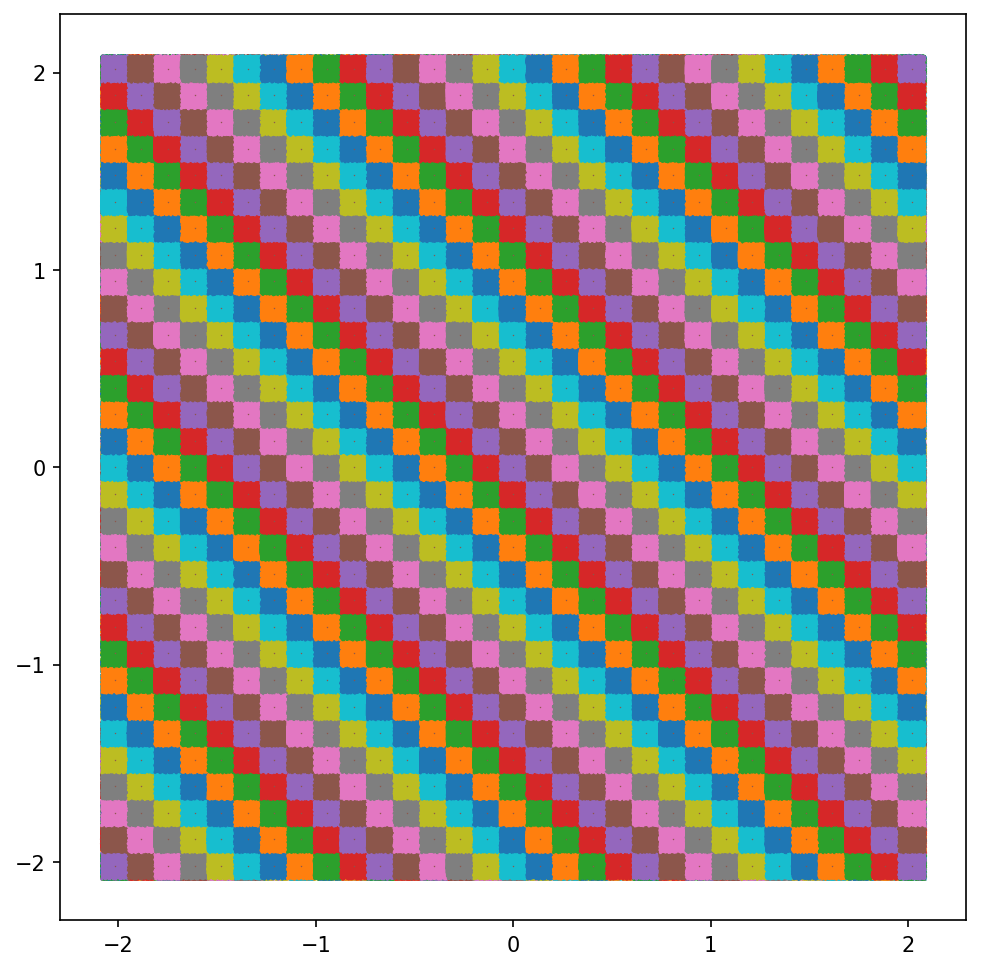

In [6]:
pos_filename = fdr + 'V1_allpos'+theme+'.bin'
fig = plt.figure(figsize = [16, 8], dpi = 150)
ax = fig.add_subplot(111)
pos = np.empty(nLayer, dtype = object)
marker = ('s', '^', 'o')
block_center = np.empty(nLayer, dtype = object)
with open(pos_filename, 'wb') as f:
    np.array([nLayer]).astype('u4').tofile(f)
    nblock.astype('u4').tofile(f)
    blockSize.astype('u4').tofile(f)
    for i in range(nLayer):
        pos_range = np.array([-grid_1D[i]/2, grid_1D[i]/2])*per_dis[0]
        #print(pos_range)
        pos[i] = np.zeros((nblock[i], 2, blockSize[i]), dtype = 'f8')
        block_center[i] = np.zeros((nblock[i],2))
        block_center[i][:,0] = np.tile((np.arange(grid_1D[i])-grid_1D[i]/2 + 1/2)*per_dis[i], grid_1D[i])
        block_center[i][:,1] = np.repeat((np.arange(grid_1D[i])-grid_1D[i]/2 + 1/2)*per_dis[i], grid_1D[i])
        fpos = np.zeros((2,nblock[i]*blockSize[i]), dtype = 'f8')
        for j in range(nblock[i]):
            pos[i][j,:,:] = square_pos(np.array([per_dis[i], per_dis[i]]), blockSize[i], block_center[i][j,:])
            fpos[0,j*blockSize[i]:(j+1)*blockSize[i]] = pos[i][j,0,:]
            fpos[1,j*blockSize[i]:(j+1)*blockSize[i]] = pos[i][j,1,:]
            ax.plot(pos[i][j,0,:], pos[i][j,1,:], marker = marker[i], ms = 0.04)
        ax.plot(block_center[i][:,0], block_center[i][:,1], '*', ms = 0.1)
        fpos.tofile(f)
        vpos = (fpos - pos_range[0])/(pos_range[1]-pos_range[0])*2*ecc-ecc
        vpos.astype('f8').tofile(f)
ax.set_aspect('equal')

In [7]:
# features: OP, OD
fp = 'f4'
plot = False
OP_center_y = (np.arange(nOP_y)-nOP_y/2+1/2)*d
phase = np.pi/4
if plot:
    fig = plt.figure(figsize = [24, 8], dpi = 150)
    marker = ('s', '^', 'o')
OP = np.empty(nLayer, dtype = object)
LR = np.empty(nLayer, dtype = object)
for i in range(nLayer):
    ax = fig.add_subplot(1,3,i+1)
    OP[i] = np.zeros((nblock[i],blockSize[i]), dtype = 'f4')
    LR[i] = np.zeros((nblock[i],blockSize[i]), dtype = 'f4')  # single eye
    block_r = per_dis[i] * np.sqrt(2)
    for j in range(nOP_y):
        OP_center = np.zeros((2,nOP_x))
        OP_center[0,:] = OP_center_y[j]
        OP_center[1,:] = (np.arange(nOP_x)-nOP_x/2+1/2)*d
        val0 = 1.0
        sat0 = 1.0
        for k in range(nOP_x):
            center = OP_center[:,k]
            phase0 = np.mod(k,2)*np.pi/2
            for l in range(nblock[i]):
                if np.linalg.norm(block_center[i][l,:]-center) < block_r+r*np.sqrt(2):
                    OP_set, pick = square_OP(center, r, phase+phase0, pos[i][l,:,:], np.mod(j+k,2)) #np.mod(i + j,2)
                    OP[i][l, pick] = (OP_set[pick] + np.pi/2)/np.pi
                    if plot:
                        npick = np.sum(pick)
                        hsv = np.zeros((npick,3))
                        hsv[:,1] = sat0
                        hsv[:,2] = val0
                        hue = OP[i][l,pick]
                        hsv[:,0] = hue
                        ax.scatter(pos[i][l,0,pick], pos[i][l,1,pick], s = 0.25, marker = marker[i], color = clr.hsv_to_rgb(hsv), edgecolors = 'none')
                        ax.plot(center[0],center[1], marker = marker[i], color = 'k')

In [8]:
feature_filename = fdr+'V1_feature'+theme+'.bin'
with open(feature_filename, 'wb') as f:
    nFeature = 2
    np.array([nFeature], dtype = 'u4').tofile(f)
    # feature1: OD
    nfl = 3 # V1 layers that have this feature, 0: L2/3, 1:L4-beta, 2:L4-alpha
    np.array([nfl, 0, 1, 2], dtype = 'u4').tofile(f)
    nV1.astype('u4').tofile(f)
    LR[0].astype('f4').tofile(f)
    LR[1].astype('f4').tofile(f)
    LR[2].astype('f4').tofile(f)
    # feature2: OP
    nfl = 3 # V1 layers that have this feature, 0: L2/3, 1:L4-beta, 2:L4-alpha
    np.array([nfl, 0, 1, 2], dtype = 'u4').tofile(f) 
    nV1.astype('u4').tofile(f)
    OP[0].astype('f4').tofile(f)
    OP[1].astype('f4').tofile(f)
    OP[2].astype('f4').tofile(f)
for i in range(3):
    print(np.min(LR[i]), np.max(LR[i]))
    print(np.min(OP[i]), np.max(OP[i]))

0.0 0.0
0.0 0.99999994
0.0 0.0
0.0 0.99999756
0.0 0.0
0.0 0.9999948


In [9]:
# Excluding S_on, S_off from LGN Koniocellular layers to L1, L2/3 for now

ratio = 8/np.pi # from half a circle to square
# Malpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798) # cells/deg^2
parvo_slice = lambda E: np.pi*E*parvo_den_alt(E)
result = integrate.quad(parvo_slice, 0, ecc)
nparvo = round(result[0]*ratio)
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012) # cells/deg^2
magno_slice = lambda E: np.pi*E*magno_den_alt(E)
result = integrate.quad(magno_slice, 0, ecc)
nmagno = round(result[0]*ratio)
nparvo = ((nparvo + warpSize-1)//warpSize)*warpSize
nmagno = ((nmagno + warpSize-1)//warpSize)*warpSize

# C-On:Off ~ 3:1; (Wiesel and Hubel 1966) cone-to-ganglion ~ 1:1 (McMahon et al., 2000)
# Red:Green (L:M), 1.5-2.0 overall, very large variations(Deeb et al., 2000, Bowmaker et. al., 2003)
rL_on = 0 # 6
rL_off = 1 # 2
rM_on = 2 # 3
rM_off = 3 # 1
nparvo_warp = nparvo//warpSize
nmagno_warp = nmagno//warpSize
nmagno_warp = int(round(nmagno_warp/2)) * 2
nparvo_warp = int(round(nparvo_warp/12)) * 12
nparvo = nparvo_warp * warpSize
nmagno = nmagno_warp * warpSize
print(f'{nparvo} parvo cells, {nmagno} cells')
RG_OnOff = np.zeros(nparvo)
i = 0
RG_OnOff[i:i+nparvo//12*6] = 0
i += nparvo//12*6
RG_OnOff[i:i+nparvo//12*2] = 1
i += nparvo//12*2
RG_OnOff[i:i+nparvo//12*3] = 2
i += nparvo//12*3
RG_OnOff[i:i+nparvo//12*1] = 3
i += nparvo//12*1
assert(i==nparvo)
OnOff = np.zeros(nmagno)
i = 0
OnOff[i:i+nmagno//2] = 4
i += nmagno//2
OnOff[i:i+nmagno//2] = 5
i += nmagno//2
assert(i==nmagno)

43392 parvo cells, 512 cells


 99.8%
 100.0%
22 208


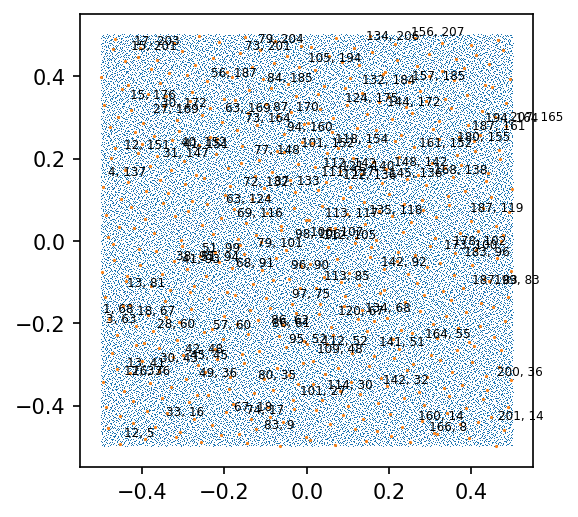

In [10]:
parvo_cart = square_pos(np.zeros(2)+ecc*2, nparvo, np.zeros(2))
magno_cart = square_pos(np.zeros(2)+ecc*2, nmagno, np.zeros(2))
magno_xyID, magno_w = assign_square_xyID(nmagno, (magno_cart + ecc)/(2*ecc))
parvo_xyID, parvo_w = assign_square_xyID(nparvo, (parvo_cart + ecc)/(2*ecc))
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111)
ax.plot(parvo_cart[0,:], parvo_cart[1,:], ',', ms = 0.5)
ax.plot(magno_cart[0,:], magno_cart[1,:], 'o', ms = 0.5)
#verify xyID 
#for i in range(nmagno):
#    ax.text(magno_cart[0,i], magno_cart[1,i], f'{magno_xyID[0,i]}, {magno_xyID[1,i]}', fontsize = 'xx-small')
for i in np.random.randint(0,nparvo,100):
    ax.text(parvo_cart[0,i], parvo_cart[1,i], f'{parvo_xyID[0,i]}, {parvo_xyID[1,i]}', fontsize = 'xx-small')
ax.set_aspect('equal')
print(magno_w, parvo_w)

In [11]:
def cart2polar(x, y):
    theta = np.arctan2(y, x)
    r = np.sqrt(x*x + y*y)
    return theta, r
magno_polar = np.empty(magno_cart.shape)
parvo_polar = np.empty(parvo_cart.shape)
magno_polar[0,:], magno_polar[1,:] = cart2polar(magno_cart[0,:], magno_cart[1,:])
parvo_polar[0,:], parvo_polar[1,:] = cart2polar(parvo_cart[0,:], parvo_cart[1,:])

In [12]:
LGN_vpos_file = fdr + 'LGN_vpos' + theme + '.bin'
with open(LGN_vpos_file, 'wb') as f:
    #       #type,  # ipsi-     | # contra-
    np.array([2, nparvo, nmagno, 0, 0], dtype = 'u4').tofile(f)
    np.array([ecc], dtype = fp).tofile(f)
    # cart
    #         xmin, xmax, ymin, ymax
    np.array([-ecc, 2*ecc, -ecc, 2*ecc], dtype = fp).tofile(f)
    parvo_cart.astype(fp).tofile(f)
    magno_cart.astype(fp).tofile(f)
    # type
    np.hstack((RG_OnOff, OnOff)).astype('u4').tofile(f)
    # polar
    parvo_polar.astype(fp).tofile(f)
    magno_polar.astype(fp).tofile(f)

In [13]:
LGNsurface_ID_file = fdr + 'LGNsurface_ID' + theme + '.bin'
with open(LGNsurface_ID_file, 'wb') as f:
    np.array([2], dtype = 'u4').tofile(f)
    np.array([nparvo], dtype = 'u4').tofile(f)
    np.array([parvo_w, parvo_w]).astype('u4').tofile(f)
    parvo_xyID.tofile(f)
    np.array([nmagno], dtype = 'u4').tofile(f)
    np.array([magno_w, magno_w]).astype('u4').tofile(f)
    magno_xyID.tofile(f)